In [77]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import missingno as msno

In [ ]:
# Load the data from the CSV file
df = pd.read_csv("../datasets/kangaroo-cleaned.csv")

# Display the first few rows to verify the data was loaded correctly
df.head(1)

,subtype,bedroomCount,bathroomCount,habitableSurface,hasDressingRoom,buildingCondition,buildingConstructionYear,facedeCount,hasLift,heatingType,...,hasArmoredDoor,hasVisiophone,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,price,epc_kwh
0,HOUSE,4.0,2.0,270.0,0,1.0,1910.0,2.0,0,3.0,...,0,0,1,3.0,0,0,1,1.0,895000.0,325.0


---

## Missing values

<Axes: >

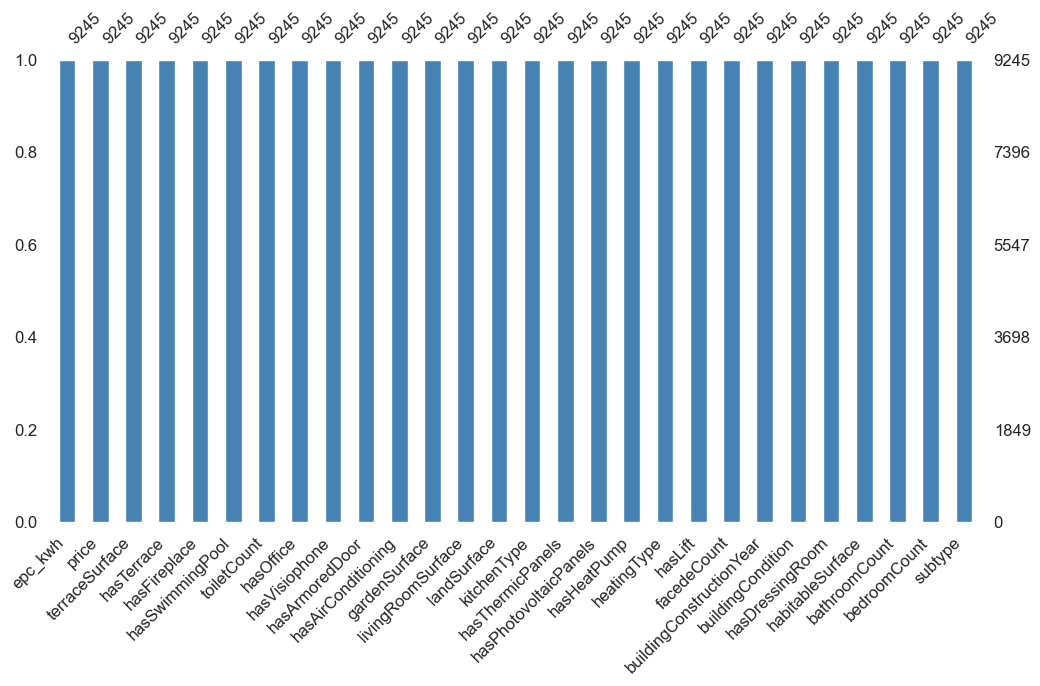

In [79]:
# Replace all -1 values with NaN across the dataframe
df = df.replace(-1, pd.NA)

# Better visualization of missing values
msno.bar(df, color="steelblue", figsize=(12, 6), fontsize=12, sort="descending") 


Revert to -1 for analysis

In [80]:
df.replace(pd.NA, -1, inplace=True)

---

## Heatmap of correlation

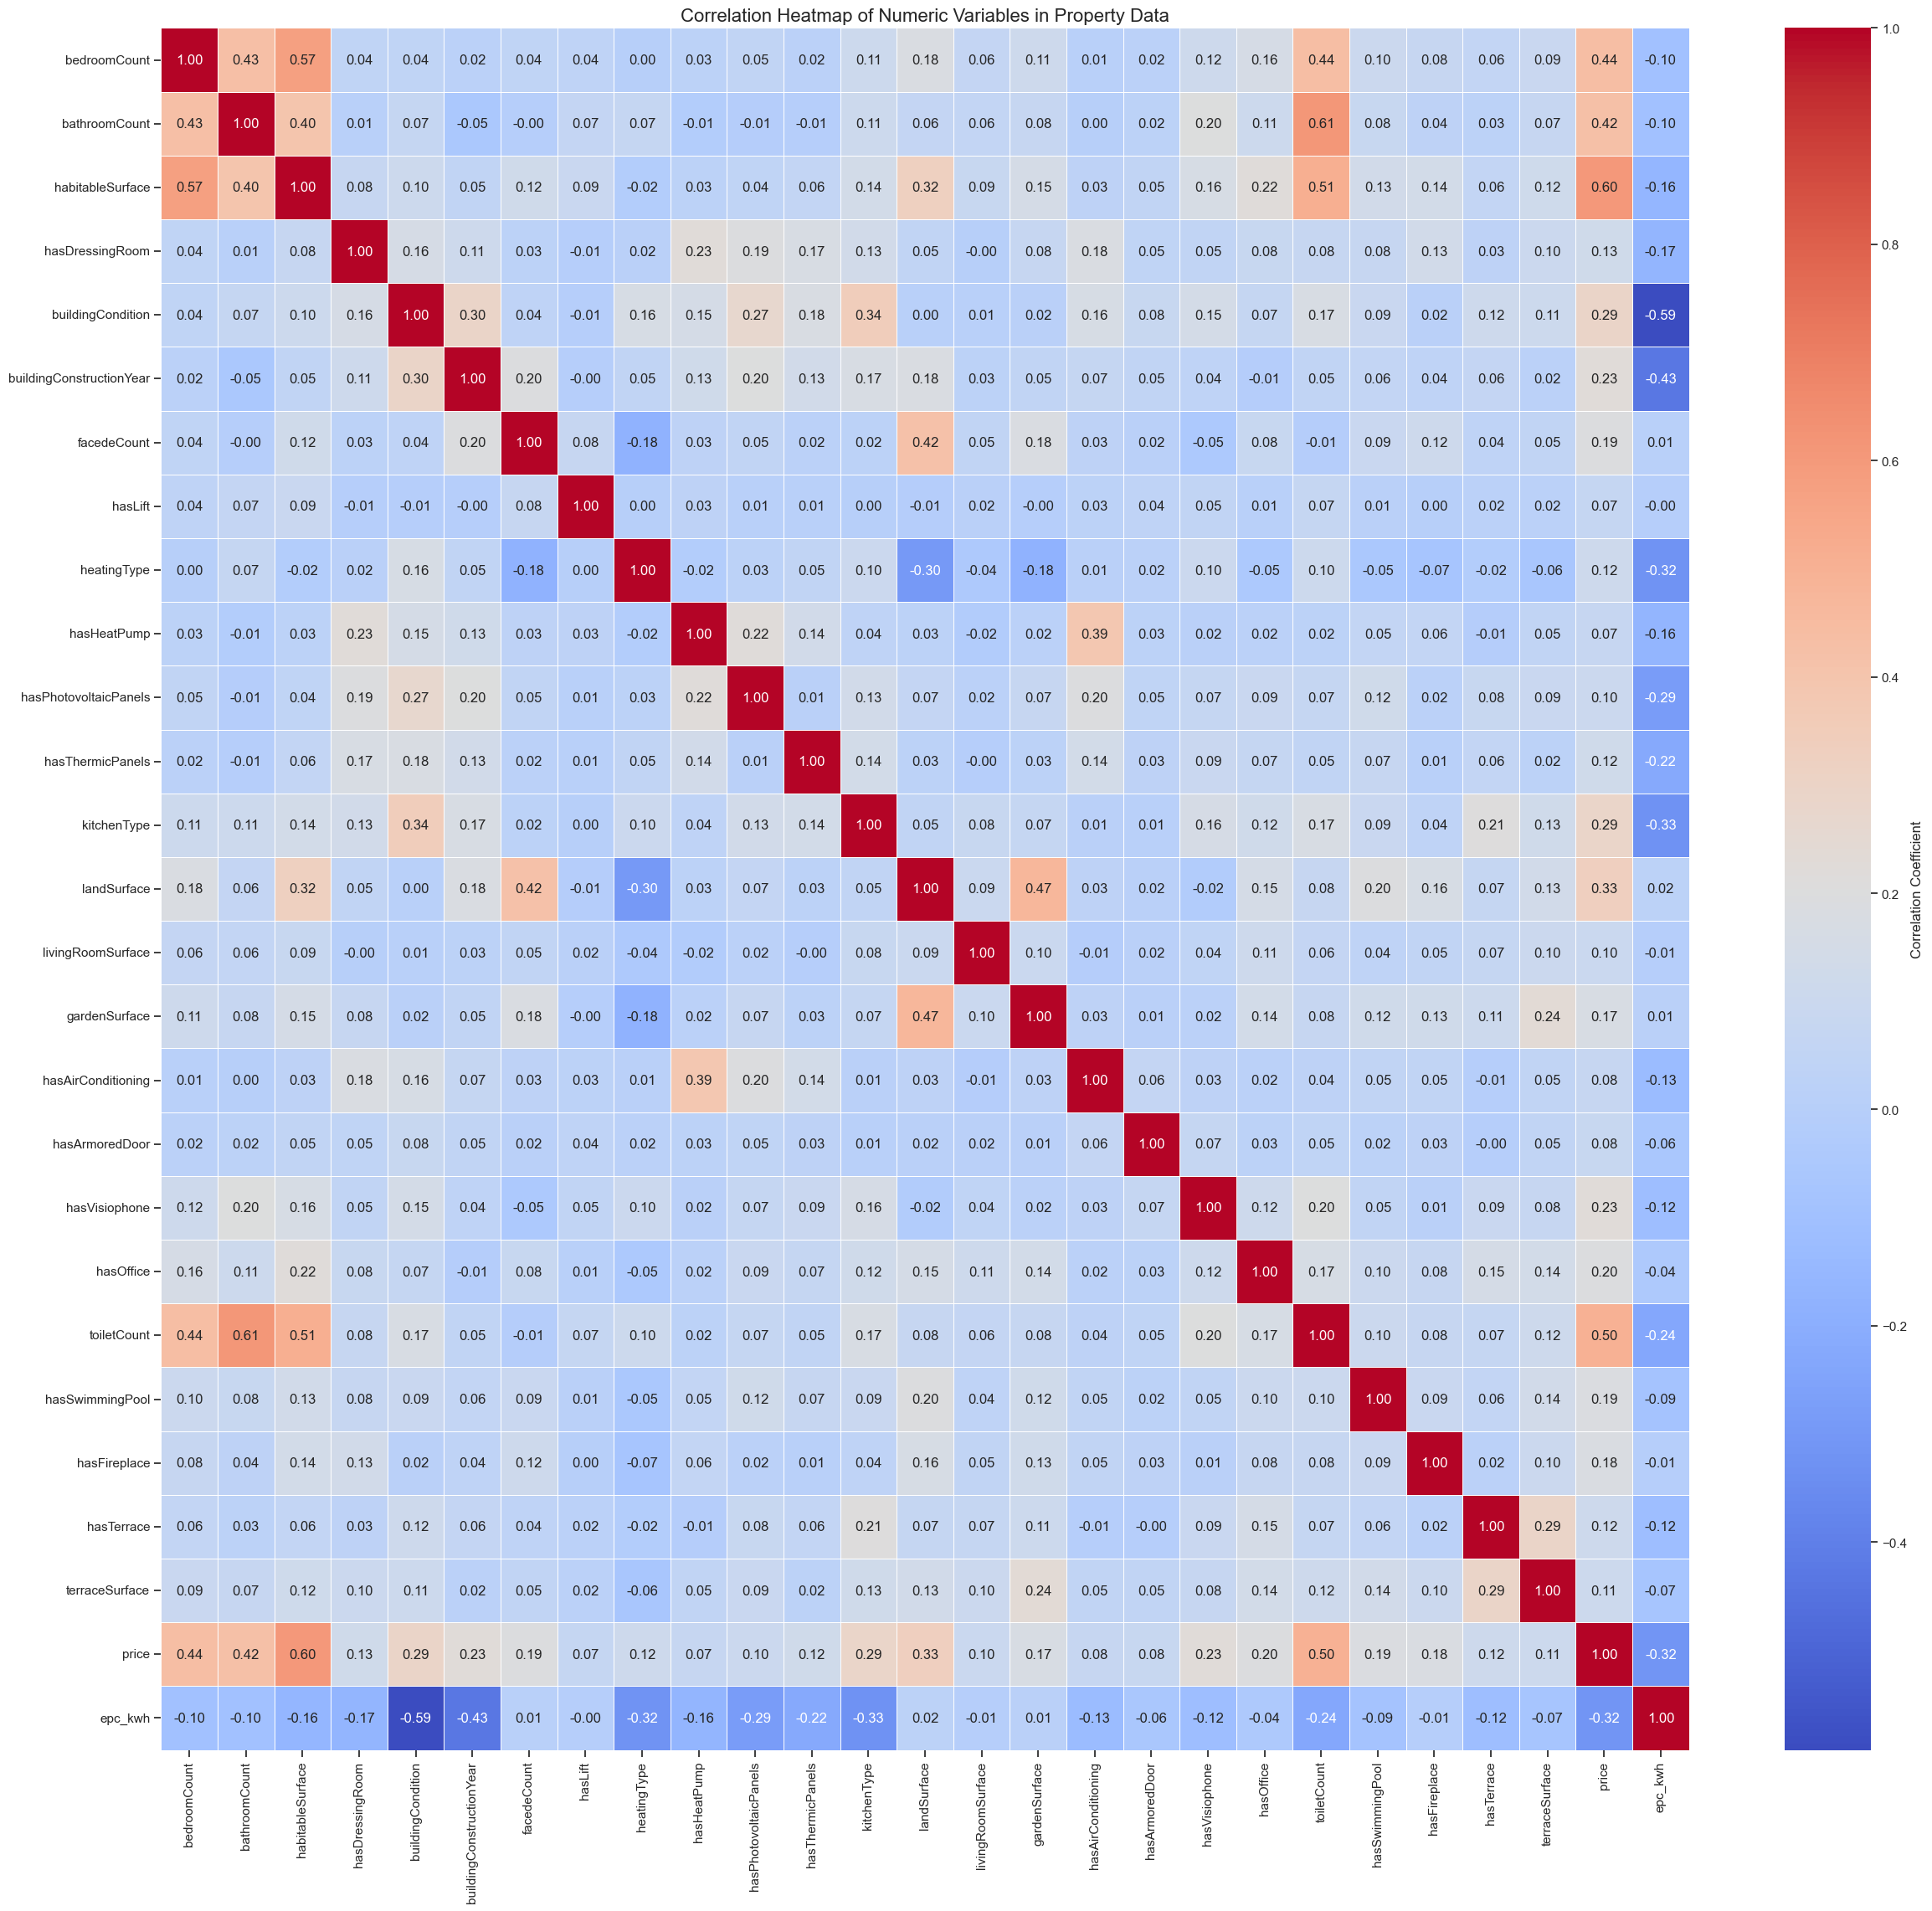

In [81]:
# Calculate the correlation matrix, excluding propertyId
correlation_matrix = df.drop(columns=['subtype']).corr()

# Create a figure with appropriate size
plt.figure(figsize=(25, 23))

# Create a heatmap with value labels
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show values on the heatmap
    cmap='coolwarm',  # Color map
    fmt='.2f',  # Format for the annotations (2 decimal places)
    linewidths=0.5,  # Width of the lines that divide each cell
    cbar_kws={'label': 'Correlation Coefficient'}  # Colorbar label
)

# Set title
plt.title('Correlation Heatmap of Numeric Variables in Property Data', fontsize=16)

# Adjust layout
plt.tight_layout()

# Display the heatmap
plt.show()

## Zoomed-In HeatMap

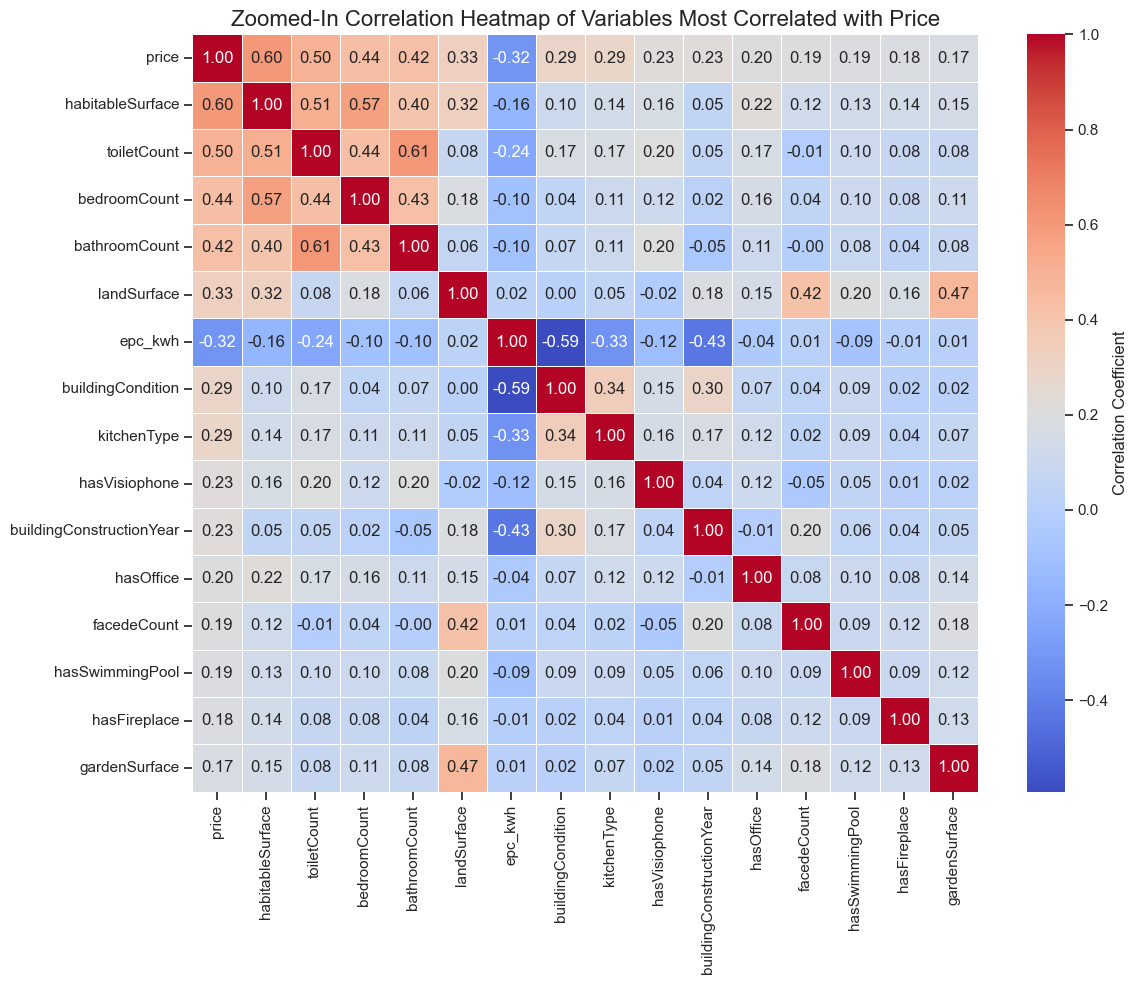

['price',
 'habitableSurface',
 'toiletCount',
 'bedroomCount',
 'bathroomCount',
 'landSurface',
 'epc_kwh',
 'buildingCondition',
 'kitchenType',
 'hasVisiophone',
 'buildingConstructionYear',
 'hasOffice',
 'facedeCount',
 'hasSwimmingPool',
 'hasFireplace',
 'gardenSurface']

In [82]:
# Select features with strongest correlation to price (absolute value > 0.09)
price_correlations = correlation_matrix['price'].abs().sort_values(ascending=False)
top_correlated = price_correlations[price_correlations > 0.15].index.tolist()

# Always include price in the visualization
if 'price' not in top_correlated:
    top_correlated.append('price')

# Create a smaller correlation matrix with just these features
zoomed_correlation = correlation_matrix.loc[top_correlated, top_correlated]

# Create a figure with appropriate size
plt.figure(figsize=(12, 10))

# Create a heatmap with value labels
heatmap = sns.heatmap(
    zoomed_correlation, 
    annot=True,  # Show values on the heatmap
    cmap='coolwarm',  # Color map
    fmt='.2f',  # Format for the annotations (2 decimal places)
    linewidths=0.5,  # Width of the lines that divide each cell
    cbar_kws={'label': 'Correlation Coefficient'}  # Colorbar label
)

# Set title
plt.title('Zoomed-In Correlation Heatmap of Variables Most Correlated with Price', fontsize=16)

# Adjust layout
plt.tight_layout()

# Display the heatmap
plt.show()
top_correlated

--- 

## Min & Max Price

In [83]:
max = df['price'].max()
min = df['price'].min()

print(f"Max price: {max}")
print(f"Min price: {min}")

Max price: 1225000.0
Min price: 44999.0


## Price related plots
---
### Price Distribution

<Axes: xlabel='price', ylabel='Count'>

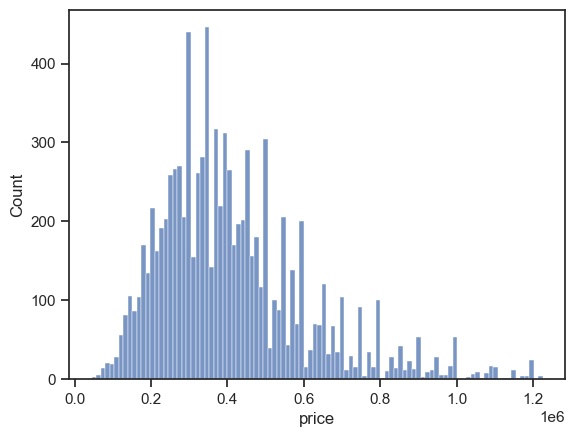

In [84]:
sns.histplot(df['price'], bins=100)

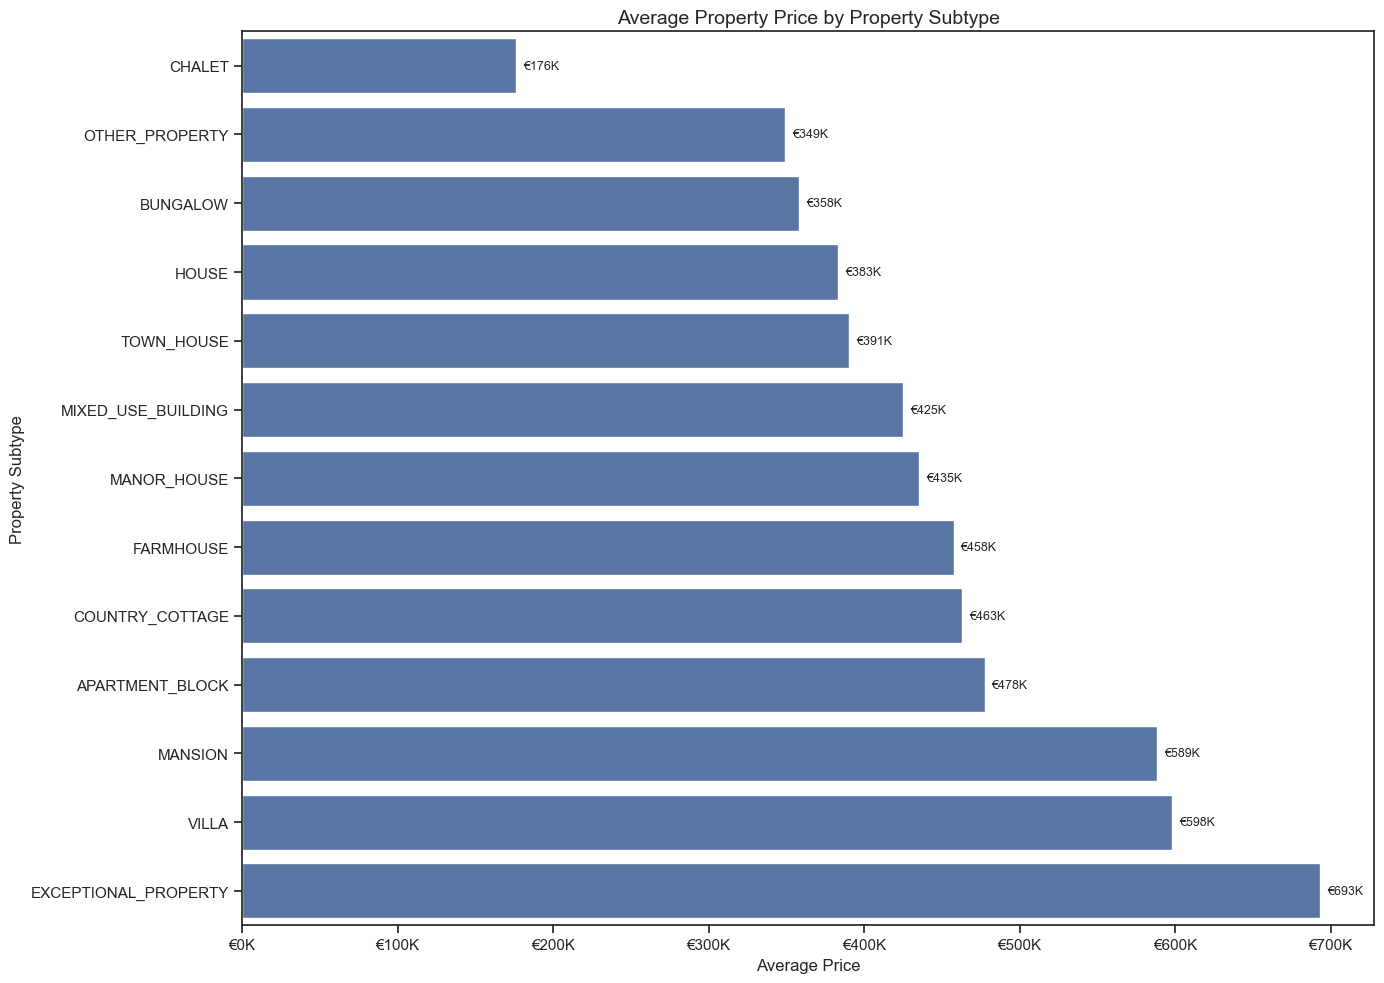

In [85]:
# Calculate mean price by subtype of property
subtype_mean_prices = df.groupby('subtype')['price'].mean().reset_index()


# Sort by average price
subtype_mean_prices = subtype_mean_prices.sort_values('price')

# Create the bar chart with better formatting
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='price', y='subtype', data=subtype_mean_prices)

# Format the x-axis to show prices in thousands or millions
def price_formatter(x, pos):
    if x >= 1000000:
        return f'€{x/1000000:.1f}M'
    else:
        return f'€{x/1000:.0f}K'

plt.gca().xaxis.set_major_formatter(FuncFormatter(price_formatter))

# Set labels and title
plt.title('Average Property Price by Property Subtype', fontsize=14)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Property Subtype', fontsize=12)

# Add data labels on the bars
for p in ax.patches:
    ax.annotate(f'{price_formatter(p.get_width(), None)}', 
                (p.get_width(), p.get_y() + p.get_height()/2),
                ha = 'left', va = 'center', fontsize=9, xytext=(5, 0), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


---

## Scatter Plots

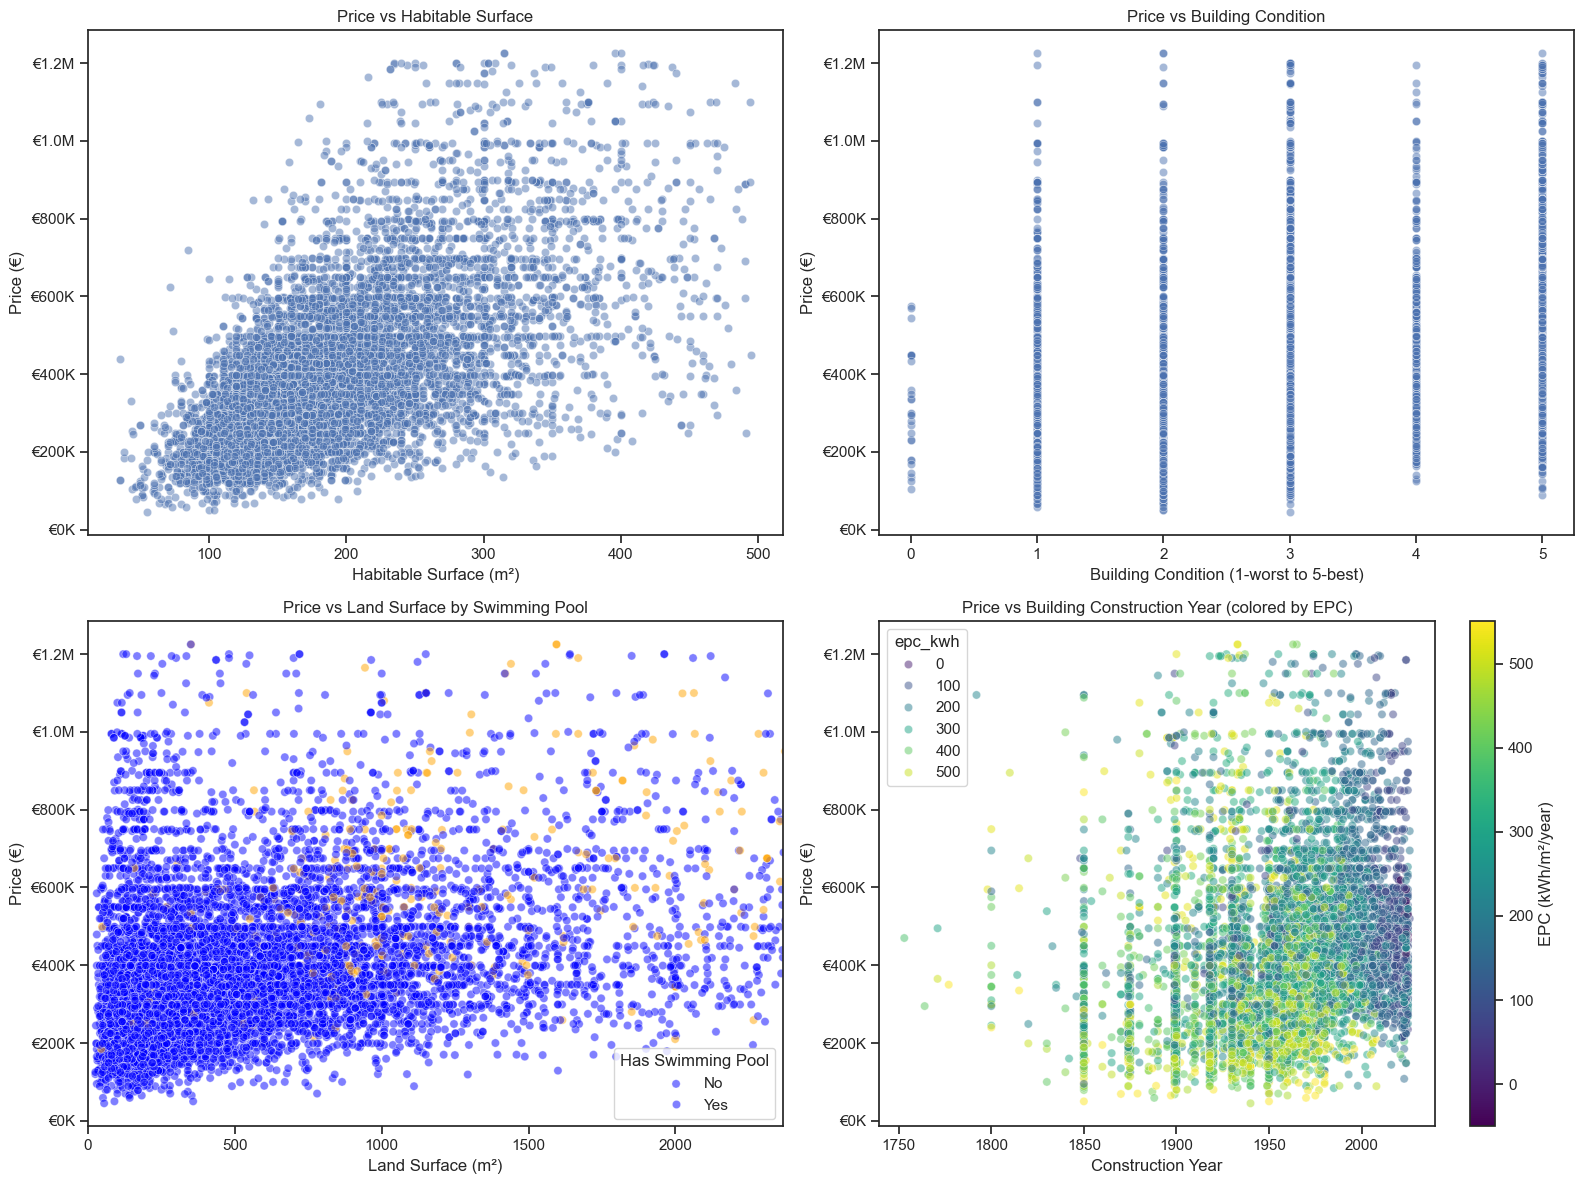

In [86]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Price vs Habitable Surface (strongest correlation with price)
sns.scatterplot(x='habitableSurface', y='price', data=df, alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Price vs Habitable Surface')
axes[0, 0].set_xlabel('Habitable Surface (m²)')
axes[0, 0].set_ylabel('Price (€)')
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(price_formatter))

# Plot 2: Price vs Building Condition (showing relationship with property quality)
sns.scatterplot(x='buildingCondition', y='price', data=df, alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Price vs Building Condition')
axes[0, 1].set_xlabel('Building Condition (1-worst to 5-best)')
axes[0, 1].set_ylabel('Price (€)')
axes[0, 1].yaxis.set_major_formatter(FuncFormatter(price_formatter))

# Plot 3: Price vs Land Surface with Swimming Pool as hue
sns.scatterplot(x='landSurface', y='price', hue='hasSwimmingPool', 
                data=df, alpha=0.5, ax=axes[1, 0], palette={0: 'blue', 1: 'orange'})
axes[1, 0].set_title('Price vs Land Surface by Swimming Pool')
axes[1, 0].set_xlabel('Land Surface (m²)')
axes[1, 0].set_ylabel('Price (€)')
axes[1, 0].legend(title='Has Swimming Pool', labels=['No', 'Yes'])
axes[1, 0].yaxis.set_major_formatter(FuncFormatter(price_formatter))
# Limit x-axis for better visualization (excluding extreme outliers)
axes[1, 0].set_xlim(0, df['landSurface'].quantile(0.98))

# Plot 4: Price vs Building Construction Year with Colored EPC Values
scatter = sns.scatterplot(x='buildingConstructionYear', y='price', 
                         hue='epc_kwh', data=df, alpha=0.5, ax=axes[1, 1],
                         palette='viridis')
axes[1, 1].set_title('Price vs Building Construction Year (colored by EPC)')
axes[1, 1].set_xlabel('Construction Year')
axes[1, 1].set_ylabel('Price (€)')
axes[1, 1].yaxis.set_major_formatter(FuncFormatter(price_formatter))
# Add a colorbar for the EPC values
norm = plt.Normalize(df['epc_kwh'].min(), df['epc_kwh'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axes[1, 1], label='EPC (kWh/m²/year)')

plt.tight_layout()
plt.show()

---

## Pair Plots

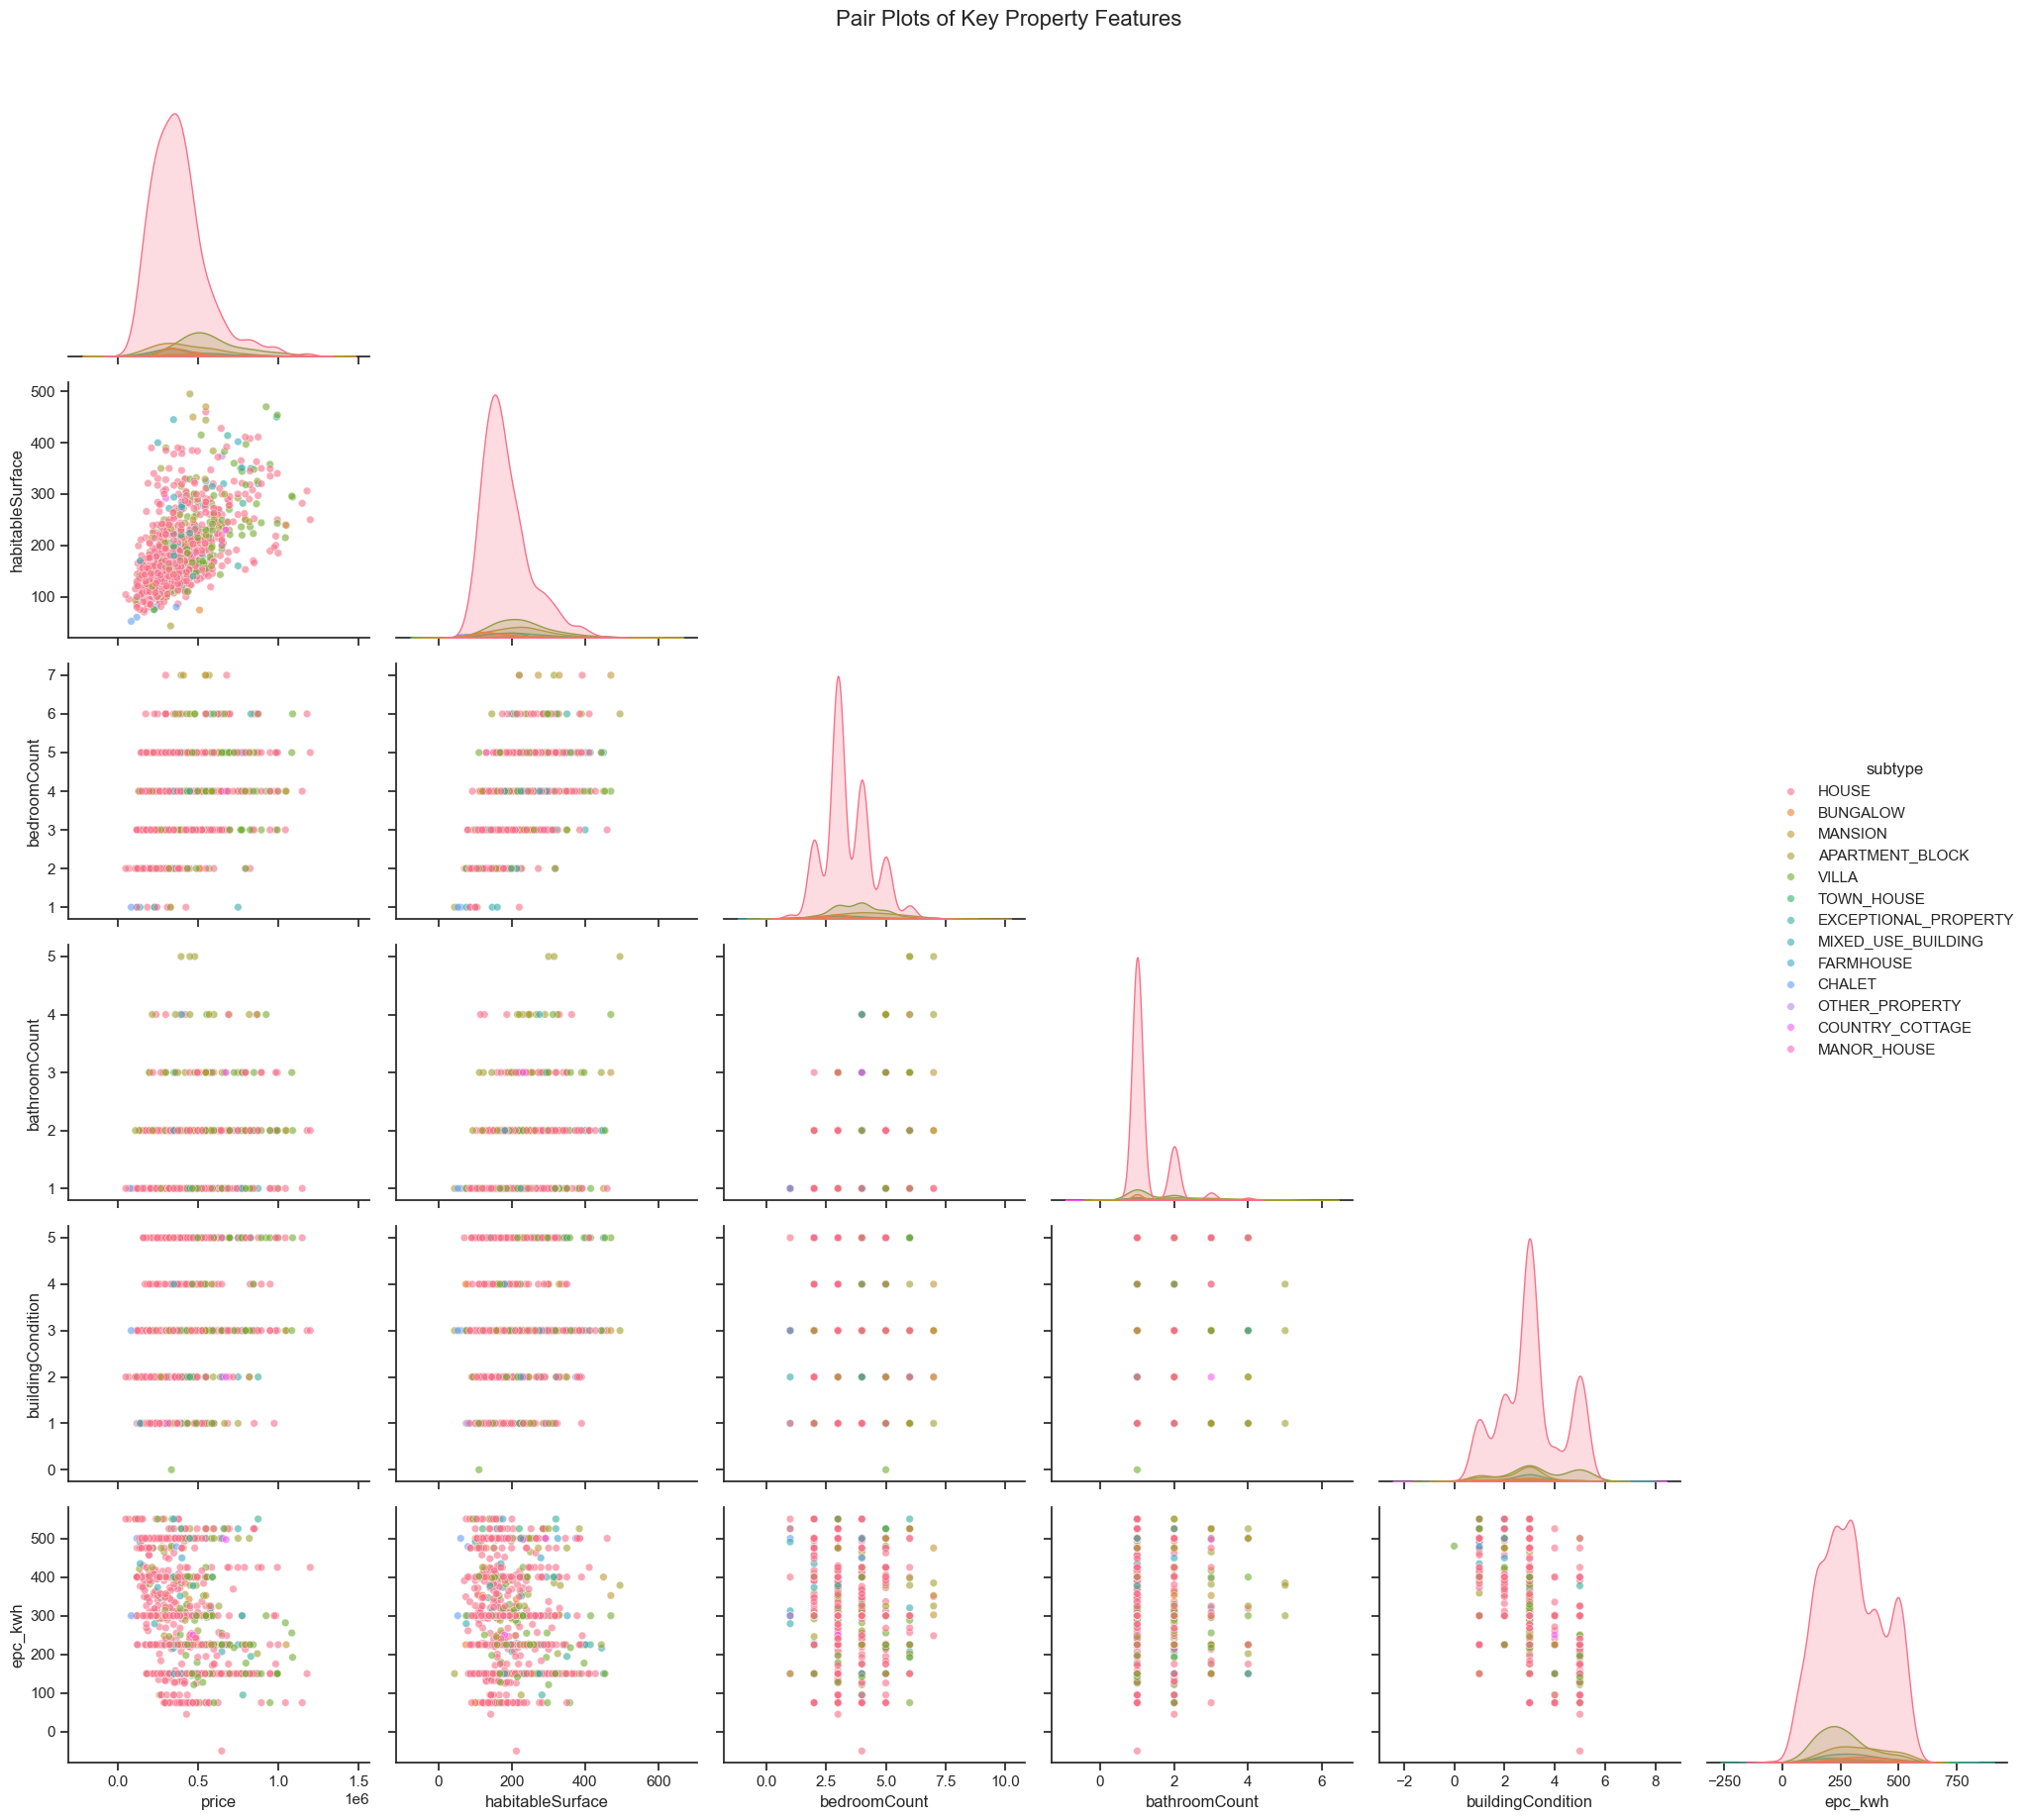

In [87]:
# Select the most important features for pairplot
features_for_pairplot = ['price', 'habitableSurface', 'bedroomCount', 'bathroomCount', 'buildingCondition', 'epc_kwh']

# Create a subset of the data to avoid overcrowding (1000 random samples)
sample_df = df.sample(n=1000, random_state=42)

# Create the pairplot with color by property subtype
g = sns.pairplot(
    sample_df,
    vars=features_for_pairplot, 
    hue='subtype',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 30},
    height=3,
    corner=True
)

# Format price axis labels to show in thousands or millions
for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
    ax = g.axes[i, j]
    if ax is not None:
        if 'price' in ax.get_xlabel() or 'price' in ax.get_ylabel():
            if 'price' in ax.get_xlabel():
                ax.xaxis.set_major_formatter(FuncFormatter(price_formatter))
            if 'price' in ax.get_ylabel():
                ax.yaxis.set_major_formatter(FuncFormatter(price_formatter))

# Add a title
g.fig.suptitle('Pair Plots of Key Property Features', y=1.02, fontsize=16)
g.fig.tight_layout()

# Show the plot
plt.show()